<a href="https://colab.research.google.com/github/SkyJoyTianle/xiaoxixi/blob/master/TripletMarginLossMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install pydot
!pip install tensorwatch

In [40]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Anyfile Notepad Files',
 'Colab Notebooks',
 'cs231n',
 'GoodNotes',
 'OneDrive_1_2020-11-17',
 'MNIST',
 '1121',
 'TripletMarginLossMNIST.ipynb']

In [41]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(dataset, model, accuracy_calculator):
    embeddings, labels = get_all_embeddings(dataset, model)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(embeddings, 
                                                embeddings,
                                                np.squeeze(labels),
                                                np.squeeze(labels),
                                                True)
    print("Test set accuracy (MAP@10) = {}".format(accuracies["mean_average_precision_at_r"]))
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [42]:
device = torch.device("cuda")

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

batch_size = 256

dataset1 = datasets.MNIST('.', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('.', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=256)
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1


### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
accuracy_calculator = AccuracyCalculator(include = ("mean_average_precision_at_r",), k = 10)
### pytorch-metric-learning stuff ###


for epoch in range(1, num_epochs+1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test(dataset2, model, accuracy_calculator)
print("num_epochs:",num_epochs)

Epoch 1 Iteration 0: Loss = 0.12698741257190704, Number of mined triplets = 512409
Epoch 1 Iteration 20: Loss = 0.11831216514110565, Number of mined triplets = 340289
Epoch 1 Iteration 40: Loss = 0.12606947124004364, Number of mined triplets = 282871
Epoch 1 Iteration 60: Loss = 0.11583507806062698, Number of mined triplets = 216484
Epoch 1 Iteration 80: Loss = 0.1117485910654068, Number of mined triplets = 181058
Epoch 1 Iteration 100: Loss = 0.11327099800109863, Number of mined triplets = 150081
Epoch 1 Iteration 120: Loss = 0.1114821806550026, Number of mined triplets = 154243
Epoch 1 Iteration 140: Loss = 0.11029930412769318, Number of mined triplets = 144124
Epoch 1 Iteration 160: Loss = 0.11137939244508743, Number of mined triplets = 146932
Epoch 1 Iteration 180: Loss = 0.10521911084651947, Number of mined triplets = 150019
Epoch 1 Iteration 200: Loss = 0.11337874084711075, Number of mined triplets = 171238
Epoch 1 Iteration 220: Loss = 0.1057862639427185, Number of mined triplet

100%|██████████| 313/313 [00:03<00:00, 78.64it/s] 


Computing accuracy
Test set accuracy (MAP@10) = 0.4503055317460317
num_epochs: 1


In [50]:
# self data
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import axes3d
#%matplotlib notebook
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def show_2D_tSNE(latent_vecs, target, title='t-SNE viz'):
    latent_vecs = latent_vecs
    latent_vecs_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent_vecs)
    plt.scatter(latent_vecs_reduced[:, 0], latent_vecs_reduced[:, 1],
                c=target, cmap='jet')
    plt.colorbar()
    plt.show()


def show_3D_tSNE(latent_vecs, target, title='3D t-SNE viz'):
    latent_vecs = latent_vecs
    tsne = TSNE(n_components=3, random_state=0).fit_transform(latent_vecs)
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter3D(tsne[:, 0], tsne[:, 1], tsne[:, 2], c=target, cmap='jet')
    ax.set_title(title)
    plt.colorbar(scatter)
    plt.show()


def show_as_PCA(latent_vecs, target, title='PCA viz'):
    latent_vecs = latent_vecs
    #latent_vecs_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent_vecs)
    latent_vecs_reduced = PCA(n_components=2).fit_transform(latent_vecs)
    plt.scatter(latent_vecs_reduced[:, 0], latent_vecs_reduced[:, 1],
                c=target, cmap='jet')
    plt.colorbar()
    plt.show()

ROOT_TRAIN = r'/content/drive/MyDrive/OneDrive_1_2020-11-17/dataset1'
ROOT_TEST = r'/content/drive/MyDrive/OneDrive_1_2020-11-17/dataset2'
ROOT = r'/content/drive/MyDrive/1121'
# 将图像RGB三个通道的像素值分别减去0.5再除以0.5，从而将所有像素值
# 固定到[-1.0, 1.0]范围内
normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
train_transform = transforms.Compose([
    transforms.Resize((28, 28)), # 裁剪为64 * 64
    transforms.RandomVerticalFlip(), # 随机垂直翻转
    transforms.ToTensor(), # 将0-255范围的像素转为0-1.0范围的tensor
    normalize])
test_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    normalize])
dataset = ImageFolder(ROOT, transform=train_transform)
train_dataset = ImageFolder(ROOT_TRAIN, transform=train_transform)
test_dataset = ImageFolder(ROOT_TEST, transform=test_transform)
print(len(train_dataset),len(test_dataset))
data = torch.utils.data.DataLoader(train_dataset, batch_size=89,shuffle=True)
data2 = torch.utils.data.DataLoader(test_dataset, batch_size=89,shuffle=True)
data3 = torch.utils.data.DataLoader(dataset, batch_size=611,shuffle=True)
print(train_dataset.class_to_idx)
print(len(dataset))
print(dataset.class_to_idx)

89 89
{'NG': 0, 'OK': 1}
611
{'NG': 0, 'OK': 1}


AttributeError: ignored

In [44]:
#  可视化训练数据集的一个batch的样本来查看图像内容
for step, (b_x, b_y) in enumerate(data3):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸，都是torch格式的数据
print(b_x.shape)
print(b_y.shape)
## 可视化前将数据集转化为numpy中的数组形式
batch_x = b_x.data.numpy()
batch_y = b_y.data.numpy()
print(batch_x.shape)
print(batch_y.shape)
# # 可视化50张图像的内容
# plt.figure(figsize=(15,8))
# for ii in np.arange(len(batch_y)):
#     plt.subplot(9,10,ii+1)
#     plt.imshow(batch_x[ii,0,:,:],cmap=plt.cm.gray)
#     plt.title(batch_y[ii])
#     plt.axis("off")
# plt.subplots_adjust(hspace = 0.3)

torch.Size([611, 3, 28, 28])
torch.Size([611])
(611, 3, 28, 28)
(611,)


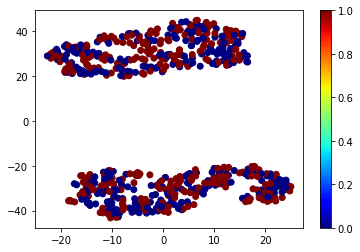

In [45]:
# raw_x = np.array([a.data.numpy() for a in data.valid_ds.x])
# raw_y = np.array([int(y.obj) for y in data.valid_ds.y])
batch_x = batch_x.reshape((len(batch_x), -1))

if False: # for saving time
    LIMIT = 1000
    chosen_idxes = np.random.choice(list(range(len(batch_x))), LIMIT)
    batch_x = batch_x[chosen_idxes]
    batch_y = batch_y[chosen_idxes]

show_2D_tSNE(batch_x, batch_y, 'Raw sample distributions (t-SNE)')

In [52]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
from torchvision import datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import faiss
res = faiss.StandardGpuResources()
res.setTempMemory(512 * 1024 * 1024)
from sklearn.model_selection import KFold, cross_val_score, train_test_split

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        # self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        # x = self.fc2(x)
        return x

### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ### 
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(dataset, model, accuracy_calculator):
    embeddings, labels = get_all_embeddings(dataset, model)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(embeddings, 
                                                embeddings,
                                                np.squeeze(labels),
                                                np.squeeze(labels),
                                                True)
    print("Test set accuracy (MAP@2) = {}".format(accuracies["mean_average_precision_at_r"]))
net2 = Net()
print(net2)
device = torch.device("cuda")

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

batch_size = 128

# #k-fold cross-validation
# kf = KFold(n_splits=5) # Define the split - into 2 folds 
# kf.get_n_splits(batch_x) # returns the number of splitting iterations in the cross-validator
# print(kf) 
# # print(batch_x)
# for train_index, test_index in kf.split(batch_x):
#   print(“TRAIN:”, train_index, “TEST:”, test_index)
# X_train, X_test = batch_x[train_index], batch_x[test_index]
# y_train, y_test = batch_y[train_index], batch_y[test_index]
# train_X,test_X,train_y,test_y = train_test_split(batch_x,batch_y,test_size=1/5,random_state=3)
fold = KFold(n_splits=5, shuffle=True, random_state=0)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
)


In [ ]:
for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(b_x, b_y)):

  print('fold {}'.format(fold_idx))

  train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, valid_idx), batch_size=batch_size, shuffle=False)
  model = Net().to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  num_epochs = 50


  ### pytorch-metric-learning stuff ###
  distance = distances.CosineSimilarity()
  reducer = reducers.ThresholdReducer(low = 0)
  loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
  mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
  accuracy_calculator = AccuracyCalculator(include = ("mean_average_precision_at_r",), k = 2)
  ### pytorch-metric-learning stuff ###

  for epoch in range(1, num_epochs):
    print("epoch:",epoch)
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    test(torch.utils.data.Subset(dataset, valid_idx), model, accuracy_calculator)

fold 0
epoch: 1
torch.Size([128, 64, 24, 24])
Epoch 1 Iteration 0: Loss = 0.11249858886003494, Number of mined triplets = 205254
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.75s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4715447154471545
epoch: 2
torch.Size([128, 64, 24, 24])
Epoch 2 Iteration 0: Loss = 0.11316102743148804, Number of mined triplets = 88298
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.87s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4247967479674797
epoch: 3
torch.Size([128, 64, 24, 24])
Epoch 3 Iteration 0: Loss = 0.1114615797996521, Number of mined triplets = 58218
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.59s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.47764227642276424
epoch: 4
torch.Size([128, 64, 24, 24])
Epoch 4 Iteration 0: Loss = 0.11007210612297058, Number of mined triplets = 50962
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.84s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4817073170731707
epoch: 5
torch.Size([128, 64, 24, 24])
Epoch 5 Iteration 0: Loss = 0.10937650501728058, Number of mined triplets = 54394
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.68s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45528455284552843
epoch: 6
torch.Size([128, 64, 24, 24])
Epoch 6 Iteration 0: Loss = 0.10855887830257416, Number of mined triplets = 52432
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.82s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4268292682926829
epoch: 7
torch.Size([128, 64, 24, 24])
Epoch 7 Iteration 0: Loss = 0.10706494748592377, Number of mined triplets = 52086
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.72s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42886178861788615
epoch: 8
torch.Size([128, 64, 24, 24])
Epoch 8 Iteration 0: Loss = 0.10747454315423965, Number of mined triplets = 53421
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.79s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3983739837398374
epoch: 9
torch.Size([128, 64, 24, 24])
Epoch 9 Iteration 0: Loss = 0.10683982074260712, Number of mined triplets = 52518
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4024390243902439
epoch: 10
torch.Size([128, 64, 24, 24])
Epoch 10 Iteration 0: Loss = 0.10566357523202896, Number of mined triplets = 50325
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.79s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48577235772357724
epoch: 11
torch.Size([128, 64, 24, 24])
Epoch 11 Iteration 0: Loss = 0.10791879892349243, Number of mined triplets = 50702
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.79s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4654471544715447
epoch: 12
torch.Size([128, 64, 24, 24])
Epoch 12 Iteration 0: Loss = 0.10579416155815125, Number of mined triplets = 51690
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.84s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4349593495934959
epoch: 13
torch.Size([128, 64, 24, 24])
Epoch 13 Iteration 0: Loss = 0.10580017417669296, Number of mined triplets = 51401
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.80s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45121951219512196
epoch: 14
torch.Size([128, 64, 24, 24])
Epoch 14 Iteration 0: Loss = 0.10522513836622238, Number of mined triplets = 50910
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4532520325203252
epoch: 15
torch.Size([128, 64, 24, 24])
Epoch 15 Iteration 0: Loss = 0.10632583498954773, Number of mined triplets = 51811
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.77s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.46747967479674796
epoch: 16
torch.Size([128, 64, 24, 24])
Epoch 16 Iteration 0: Loss = 0.10550511628389359, Number of mined triplets = 50833
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.82s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5365853658536586
epoch: 17
torch.Size([128, 64, 24, 24])
Epoch 17 Iteration 0: Loss = 0.10455929487943649, Number of mined triplets = 48936
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.57s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4898373983739837
epoch: 18
torch.Size([128, 64, 24, 24])
Epoch 18 Iteration 0: Loss = 0.10589197278022766, Number of mined triplets = 52265
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.56s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4715447154471545
epoch: 19
torch.Size([128, 64, 24, 24])
Epoch 19 Iteration 0: Loss = 0.10511482506990433, Number of mined triplets = 51297
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.74s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4735772357723577
epoch: 20
torch.Size([128, 64, 24, 24])
Epoch 20 Iteration 0: Loss = 0.1034843847155571, Number of mined triplets = 49549
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.77s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4735772357723577
epoch: 21
torch.Size([128, 64, 24, 24])
Epoch 21 Iteration 0: Loss = 0.10484741628170013, Number of mined triplets = 49660
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.70s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5426829268292683
epoch: 22
torch.Size([128, 64, 24, 24])
Epoch 22 Iteration 0: Loss = 0.10437701642513275, Number of mined triplets = 51072
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.52s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4817073170731707
epoch: 23
torch.Size([128, 64, 24, 24])
Epoch 23 Iteration 0: Loss = 0.10310611128807068, Number of mined triplets = 50892
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5
epoch: 24
torch.Size([128, 64, 24, 24])
Epoch 24 Iteration 0: Loss = 0.10326210409402847, Number of mined triplets = 49655
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.75s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4878048780487805
epoch: 25
torch.Size([128, 64, 24, 24])
Epoch 25 Iteration 0: Loss = 0.10263800621032715, Number of mined triplets = 50306
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4451219512195122
epoch: 26
torch.Size([128, 64, 24, 24])
Epoch 26 Iteration 0: Loss = 0.10312840342521667, Number of mined triplets = 50124
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.57s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.47764227642276424
epoch: 27
torch.Size([128, 64, 24, 24])
Epoch 27 Iteration 0: Loss = 0.10374947637319565, Number of mined triplets = 50792
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.50s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4329268292682927
epoch: 28
torch.Size([128, 64, 24, 24])
Epoch 28 Iteration 0: Loss = 0.10315952450037003, Number of mined triplets = 49876
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.76s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5121951219512195
epoch: 29
torch.Size([128, 64, 24, 24])
Epoch 29 Iteration 0: Loss = 0.10490492731332779, Number of mined triplets = 54246
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.77s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.483739837398374
epoch: 30
torch.Size([128, 64, 24, 24])
Epoch 30 Iteration 0: Loss = 0.10258810222148895, Number of mined triplets = 48411
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.67s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5386178861788617
epoch: 31
torch.Size([128, 64, 24, 24])
Epoch 31 Iteration 0: Loss = 0.10238131880760193, Number of mined triplets = 49866
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.508130081300813
epoch: 32
torch.Size([128, 64, 24, 24])
Epoch 32 Iteration 0: Loss = 0.10251902043819427, Number of mined triplets = 51010
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5426829268292683
epoch: 33
torch.Size([128, 64, 24, 24])
Epoch 33 Iteration 0: Loss = 0.10242445021867752, Number of mined triplets = 50068
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4369918699186992
epoch: 34
torch.Size([128, 64, 24, 24])
Epoch 34 Iteration 0: Loss = 0.10358651727437973, Number of mined triplets = 49622
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.73s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4491869918699187
epoch: 35
torch.Size([128, 64, 24, 24])
Epoch 35 Iteration 0: Loss = 0.10267036408185959, Number of mined triplets = 50758
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.72s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5609756097560976
epoch: 36
torch.Size([128, 64, 24, 24])
Epoch 36 Iteration 0: Loss = 0.10426003485918045, Number of mined triplets = 51503
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.55s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.51s/it]

torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5101626016260162
epoch: 37
torch.Size([128, 64, 24, 24])
Epoch 37 Iteration 0: Loss = 0.10442206263542175, Number of mined triplets = 50956
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.57s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4735772357723577
epoch: 38
torch.Size([128, 64, 24, 24])
Epoch 38 Iteration 0: Loss = 0.10348665714263916, Number of mined triplets = 49724
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.55s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5548780487804879
epoch: 39
torch.Size([128, 64, 24, 24])
Epoch 39 Iteration 0: Loss = 0.10225217044353485, Number of mined triplets = 48176
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.70s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5060975609756098
epoch: 40
torch.Size([128, 64, 24, 24])
Epoch 40 Iteration 0: Loss = 0.10478056222200394, Number of mined triplets = 53752
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4735772357723577
epoch: 41
torch.Size([128, 64, 24, 24])
Epoch 41 Iteration 0: Loss = 0.10735878348350525, Number of mined triplets = 61817
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.556910569105691
epoch: 42
torch.Size([128, 64, 24, 24])
Epoch 42 Iteration 0: Loss = 0.10568192601203918, Number of mined triplets = 53419
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.78s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5304878048780488
epoch: 43
torch.Size([128, 64, 24, 24])
Epoch 43 Iteration 0: Loss = 0.10472860187292099, Number of mined triplets = 55766
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.67s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.524390243902439
epoch: 44
torch.Size([128, 64, 24, 24])
Epoch 44 Iteration 0: Loss = 0.1025579422712326, Number of mined triplets = 51273
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

torch.Size([32, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.56s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.483739837398374
epoch: 45
torch.Size([128, 64, 24, 24])
Epoch 45 Iteration 0: Loss = 0.10350510478019714, Number of mined triplets = 49799
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.81s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.483739837398374
epoch: 46
torch.Size([128, 64, 24, 24])
Epoch 46 Iteration 0: Loss = 0.10289417207241058, Number of mined triplets = 49605
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.55s/it]

torch.Size([32, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.56s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.491869918699187
epoch: 47
torch.Size([128, 64, 24, 24])
Epoch 47 Iteration 0: Loss = 0.10273775458335876, Number of mined triplets = 47375
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.67s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4735772357723577
epoch: 48
torch.Size([128, 64, 24, 24])
Epoch 48 Iteration 0: Loss = 0.10101824998855591, Number of mined triplets = 49416
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.76s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4878048780487805
epoch: 49
torch.Size([128, 64, 24, 24])
Epoch 49 Iteration 0: Loss = 0.10469673573970795, Number of mined triplets = 51897
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([104, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.85s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([27, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4878048780487805
fold 1
epoch: 1
torch.Size([128, 64, 24, 24])
Epoch 1 Iteration 0: Loss = 0.11233088374137878, Number of mined triplets = 195615
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.52s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4692622950819672
epoch: 2
torch.Size([128, 64, 24, 24])
Epoch 2 Iteration 0: Loss = 0.11142440885305405, Number of mined triplets = 76435
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.49s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45286885245901637
epoch: 3
torch.Size([128, 64, 24, 24])
Epoch 3 Iteration 0: Loss = 0.11560473591089249, Number of mined triplets = 54560
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42827868852459017
epoch: 4
torch.Size([128, 64, 24, 24])
Epoch 4 Iteration 0: Loss = 0.11273223161697388, Number of mined triplets = 52582
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.72s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48155737704918034
epoch: 5
torch.Size([128, 64, 24, 24])
Epoch 5 Iteration 0: Loss = 0.10722951591014862, Number of mined triplets = 51833
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4610655737704918
epoch: 6
torch.Size([128, 64, 24, 24])
Epoch 6 Iteration 0: Loss = 0.10819045454263687, Number of mined triplets = 50728
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45081967213114754
epoch: 7
torch.Size([128, 64, 24, 24])
Epoch 7 Iteration 0: Loss = 0.1087828055024147, Number of mined triplets = 52886
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.52s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42213114754098363
epoch: 8
torch.Size([128, 64, 24, 24])
Epoch 8 Iteration 0: Loss = 0.11007793247699738, Number of mined triplets = 49959
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.55s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45286885245901637
epoch: 9
torch.Size([128, 64, 24, 24])
Epoch 9 Iteration 0: Loss = 0.10883735865354538, Number of mined triplets = 50481
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4651639344262295
epoch: 10
torch.Size([128, 64, 24, 24])
Epoch 10 Iteration 0: Loss = 0.10719010978937149, Number of mined triplets = 53673
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.46311475409836067
epoch: 11
torch.Size([128, 64, 24, 24])
Epoch 11 Iteration 0: Loss = 0.10709081590175629, Number of mined triplets = 51239
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.75s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42213114754098363
epoch: 12
torch.Size([128, 64, 24, 24])
Epoch 12 Iteration 0: Loss = 0.10667357593774796, Number of mined triplets = 52436
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.52s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4487704918032787
epoch: 13
torch.Size([128, 64, 24, 24])
Epoch 13 Iteration 0: Loss = 0.10554175078868866, Number of mined triplets = 51444
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42213114754098363
epoch: 14
torch.Size([128, 64, 24, 24])
Epoch 14 Iteration 0: Loss = 0.10588481277227402, Number of mined triplets = 51234
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.72s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4487704918032787
epoch: 15
torch.Size([128, 64, 24, 24])
Epoch 15 Iteration 0: Loss = 0.10639242082834244, Number of mined triplets = 50001
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.51s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42008196721311475
epoch: 16
torch.Size([128, 64, 24, 24])
Epoch 16 Iteration 0: Loss = 0.10473361611366272, Number of mined triplets = 49784
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.50s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4364754098360656
epoch: 17
torch.Size([128, 64, 24, 24])
Epoch 17 Iteration 0: Loss = 0.10480514168739319, Number of mined triplets = 50630
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4569672131147541
epoch: 18
torch.Size([128, 64, 24, 24])
Epoch 18 Iteration 0: Loss = 0.10462561249732971, Number of mined triplets = 51072
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.44672131147540983
epoch: 19
torch.Size([128, 64, 24, 24])
Epoch 19 Iteration 0: Loss = 0.10568663477897644, Number of mined triplets = 49948
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4672131147540984
epoch: 20
torch.Size([128, 64, 24, 24])
Epoch 20 Iteration 0: Loss = 0.10612849146127701, Number of mined triplets = 49809
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4098360655737705
epoch: 21
torch.Size([128, 64, 24, 24])
Epoch 21 Iteration 0: Loss = 0.10497793555259705, Number of mined triplets = 49011
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4405737704918033
epoch: 22
torch.Size([128, 64, 24, 24])
Epoch 22 Iteration 0: Loss = 0.10537970066070557, Number of mined triplets = 50296
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.42s/it]

torch.Size([32, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.46s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4344262295081967
epoch: 23
torch.Size([128, 64, 24, 24])
Epoch 23 Iteration 0: Loss = 0.10598649829626083, Number of mined triplets = 51298
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.61s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4036885245901639
epoch: 24
torch.Size([128, 64, 24, 24])
Epoch 24 Iteration 0: Loss = 0.10432583093643188, Number of mined triplets = 49017
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4385245901639344
epoch: 25
torch.Size([128, 64, 24, 24])
Epoch 25 Iteration 0: Loss = 0.10531841963529587, Number of mined triplets = 50395
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.39344262295081966
epoch: 26
torch.Size([128, 64, 24, 24])
Epoch 26 Iteration 0: Loss = 0.10304315388202667, Number of mined triplets = 50585
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.67s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42418032786885246
epoch: 27
torch.Size([128, 64, 24, 24])
Epoch 27 Iteration 0: Loss = 0.10268153995275497, Number of mined triplets = 50096
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.72s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.47950819672131145
epoch: 28
torch.Size([128, 64, 24, 24])
Epoch 28 Iteration 0: Loss = 0.10226579010486603, Number of mined triplets = 47586
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4405737704918033
epoch: 29
torch.Size([128, 64, 24, 24])
Epoch 29 Iteration 0: Loss = 0.1048726737499237, Number of mined triplets = 49825
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.67s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4405737704918033
epoch: 30
torch.Size([128, 64, 24, 24])
Epoch 30 Iteration 0: Loss = 0.10416153073310852, Number of mined triplets = 49830
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.70s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.44672131147540983
epoch: 31
torch.Size([128, 64, 24, 24])
Epoch 31 Iteration 0: Loss = 0.10385506600141525, Number of mined triplets = 49999
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4344262295081967
epoch: 32
torch.Size([128, 64, 24, 24])
Epoch 32 Iteration 0: Loss = 0.10258056968450546, Number of mined triplets = 49507
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.67s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4610655737704918
epoch: 33
torch.Size([128, 64, 24, 24])
Epoch 33 Iteration 0: Loss = 0.10523176193237305, Number of mined triplets = 51139
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

torch.Size([32, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.56s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4692622950819672
epoch: 34
torch.Size([128, 64, 24, 24])
Epoch 34 Iteration 0: Loss = 0.10399216413497925, Number of mined triplets = 50329
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4098360655737705
epoch: 35
torch.Size([128, 64, 24, 24])
Epoch 35 Iteration 0: Loss = 0.10345831513404846, Number of mined triplets = 50830
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.41188524590163933
epoch: 36
torch.Size([128, 64, 24, 24])
Epoch 36 Iteration 0: Loss = 0.10379034280776978, Number of mined triplets = 49327
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48770491803278687
epoch: 37
torch.Size([128, 64, 24, 24])
Epoch 37 Iteration 0: Loss = 0.10309737920761108, Number of mined triplets = 49400
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.51s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45491803278688525
epoch: 38
torch.Size([128, 64, 24, 24])
Epoch 38 Iteration 0: Loss = 0.10271651297807693, Number of mined triplets = 50565
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.50s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4323770491803279
epoch: 39
torch.Size([128, 64, 24, 24])
Epoch 39 Iteration 0: Loss = 0.1048947349190712, Number of mined triplets = 48860
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.61s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4672131147540984
epoch: 40
torch.Size([128, 64, 24, 24])
Epoch 40 Iteration 0: Loss = 0.10373623669147491, Number of mined triplets = 47976
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42827868852459017
epoch: 41
torch.Size([128, 64, 24, 24])
Epoch 41 Iteration 0: Loss = 0.10226316750049591, Number of mined triplets = 50103
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.49s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4672131147540984
epoch: 42
torch.Size([128, 64, 24, 24])
Epoch 42 Iteration 0: Loss = 0.10270572453737259, Number of mined triplets = 50088
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.56s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.39959016393442626
epoch: 43
torch.Size([128, 64, 24, 24])
Epoch 43 Iteration 0: Loss = 0.10360703617334366, Number of mined triplets = 49922
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42008196721311475
epoch: 44
torch.Size([128, 64, 24, 24])
Epoch 44 Iteration 0: Loss = 0.10292026400566101, Number of mined triplets = 50778
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.50s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4610655737704918
epoch: 45
torch.Size([128, 64, 24, 24])
Epoch 45 Iteration 0: Loss = 0.10392893850803375, Number of mined triplets = 50899
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3524590163934426
epoch: 46
torch.Size([128, 64, 24, 24])
Epoch 46 Iteration 0: Loss = 0.10290554910898209, Number of mined triplets = 52141
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.46s/it]

torch.Size([32, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.49s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.39549180327868855
epoch: 47
torch.Size([128, 64, 24, 24])
Epoch 47 Iteration 0: Loss = 0.10277890413999557, Number of mined triplets = 52473
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.41598360655737704
epoch: 48
torch.Size([128, 64, 24, 24])
Epoch 48 Iteration 0: Loss = 0.1028233990073204, Number of mined triplets = 49970
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.58s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3975409836065574
epoch: 49
torch.Size([128, 64, 24, 24])
Epoch 49 Iteration 0: Loss = 0.1023738756775856, Number of mined triplets = 53510
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.47s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3729508196721312
fold 2
epoch: 1
torch.Size([128, 64, 24, 24])
Epoch 1 Iteration 0: Loss = 0.1094135269522667, Number of mined triplets = 177603
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3975409836065574
epoch: 2
torch.Size([128, 64, 24, 24])
Epoch 2 Iteration 0: Loss = 0.1154773086309433, Number of mined triplets = 71794
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.70s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.47950819672131145
epoch: 3
torch.Size([128, 64, 24, 24])
Epoch 3 Iteration 0: Loss = 0.11122176796197891, Number of mined triplets = 52800
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48155737704918034
epoch: 4
torch.Size([128, 64, 24, 24])
Epoch 4 Iteration 0: Loss = 0.1052451878786087, Number of mined triplets = 53437
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.50s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42008196721311475
epoch: 5
torch.Size([128, 64, 24, 24])
Epoch 5 Iteration 0: Loss = 0.10579916834831238, Number of mined triplets = 53994
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.35860655737704916
epoch: 6
torch.Size([128, 64, 24, 24])
Epoch 6 Iteration 0: Loss = 0.1083282083272934, Number of mined triplets = 51115
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.67s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5061475409836066
epoch: 7
torch.Size([128, 64, 24, 24])
Epoch 7 Iteration 0: Loss = 0.10906347632408142, Number of mined triplets = 52606
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4405737704918033
epoch: 8
torch.Size([128, 64, 24, 24])
Epoch 8 Iteration 0: Loss = 0.10625625401735306, Number of mined triplets = 50287
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.49385245901639346
epoch: 9
torch.Size([128, 64, 24, 24])
Epoch 9 Iteration 0: Loss = 0.10507580637931824, Number of mined triplets = 51587
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.47540983606557374
epoch: 10
torch.Size([128, 64, 24, 24])
Epoch 10 Iteration 0: Loss = 0.10516712069511414, Number of mined triplets = 50073
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.36065573770491804
epoch: 11
torch.Size([128, 64, 24, 24])
Epoch 11 Iteration 0: Loss = 0.1048676073551178, Number of mined triplets = 50411
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3668032786885246
epoch: 12
torch.Size([128, 64, 24, 24])
Epoch 12 Iteration 0: Loss = 0.10699237883090973, Number of mined triplets = 48408
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.41188524590163933
epoch: 13
torch.Size([128, 64, 24, 24])
Epoch 13 Iteration 0: Loss = 0.10526420176029205, Number of mined triplets = 49134
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.72s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45081967213114754
epoch: 14
torch.Size([128, 64, 24, 24])
Epoch 14 Iteration 0: Loss = 0.10508144646883011, Number of mined triplets = 50046
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.38934426229508196
epoch: 15
torch.Size([128, 64, 24, 24])
Epoch 15 Iteration 0: Loss = 0.10554037988185883, Number of mined triplets = 48877
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.49s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42008196721311475
epoch: 16
torch.Size([128, 64, 24, 24])
Epoch 16 Iteration 0: Loss = 0.10603218525648117, Number of mined triplets = 49210
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.39139344262295084
epoch: 17
torch.Size([128, 64, 24, 24])
Epoch 17 Iteration 0: Loss = 0.10569960623979568, Number of mined triplets = 50474
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.39959016393442626
epoch: 18
torch.Size([128, 64, 24, 24])
Epoch 18 Iteration 0: Loss = 0.10573303699493408, Number of mined triplets = 49588
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.74s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.38934426229508196
epoch: 19
torch.Size([128, 64, 24, 24])
Epoch 19 Iteration 0: Loss = 0.10371877253055573, Number of mined triplets = 49418
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.60s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5
epoch: 20
torch.Size([128, 64, 24, 24])
Epoch 20 Iteration 0: Loss = 0.10543297976255417, Number of mined triplets = 50079
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.41598360655737704
epoch: 21
torch.Size([128, 64, 24, 24])
Epoch 21 Iteration 0: Loss = 0.10483414679765701, Number of mined triplets = 49317
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4016393442622951
epoch: 22
torch.Size([128, 64, 24, 24])
Epoch 22 Iteration 0: Loss = 0.10543512552976608, Number of mined triplets = 49876
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4364754098360656
epoch: 23
torch.Size([128, 64, 24, 24])
Epoch 23 Iteration 0: Loss = 0.10767284035682678, Number of mined triplets = 51395
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.55s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48360655737704916
epoch: 24
torch.Size([128, 64, 24, 24])
Epoch 24 Iteration 0: Loss = 0.10644462704658508, Number of mined triplets = 53015
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.38729508196721313
epoch: 25
torch.Size([128, 64, 24, 24])
Epoch 25 Iteration 0: Loss = 0.10471567511558533, Number of mined triplets = 50064
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.49s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.36885245901639346
epoch: 26
torch.Size([128, 64, 24, 24])
Epoch 26 Iteration 0: Loss = 0.10492996871471405, Number of mined triplets = 48973
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.67s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.430327868852459
epoch: 27
torch.Size([128, 64, 24, 24])
Epoch 27 Iteration 0: Loss = 0.10517650842666626, Number of mined triplets = 51866
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4036885245901639
epoch: 28
torch.Size([128, 64, 24, 24])
Epoch 28 Iteration 0: Loss = 0.1039729118347168, Number of mined triplets = 50735
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.46s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4057377049180328
epoch: 29
torch.Size([128, 64, 24, 24])
Epoch 29 Iteration 0: Loss = 0.10585124790668488, Number of mined triplets = 49405
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.60s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45901639344262296
epoch: 30
torch.Size([128, 64, 24, 24])
Epoch 30 Iteration 0: Loss = 0.10609655827283859, Number of mined triplets = 51363
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.51s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4487704918032787
epoch: 31
torch.Size([128, 64, 24, 24])
Epoch 31 Iteration 0: Loss = 0.10465094447135925, Number of mined triplets = 51951
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.58s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3831967213114754
epoch: 32
torch.Size([128, 64, 24, 24])
Epoch 32 Iteration 0: Loss = 0.10442367941141129, Number of mined triplets = 49255
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5102459016393442
epoch: 33
torch.Size([128, 64, 24, 24])
Epoch 33 Iteration 0: Loss = 0.10413049161434174, Number of mined triplets = 49629
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.39344262295081966
epoch: 34
torch.Size([128, 64, 24, 24])
Epoch 34 Iteration 0: Loss = 0.10514502227306366, Number of mined triplets = 50374
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.44672131147540983
epoch: 35
torch.Size([128, 64, 24, 24])
Epoch 35 Iteration 0: Loss = 0.10382836312055588, Number of mined triplets = 50752
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.57s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4057377049180328
epoch: 36
torch.Size([128, 64, 24, 24])
Epoch 36 Iteration 0: Loss = 0.10330722481012344, Number of mined triplets = 51922
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4262295081967213
epoch: 37
torch.Size([128, 64, 24, 24])
Epoch 37 Iteration 0: Loss = 0.105010487139225, Number of mined triplets = 50288
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.61s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4036885245901639
epoch: 38
torch.Size([128, 64, 24, 24])
Epoch 38 Iteration 0: Loss = 0.104296013712883, Number of mined triplets = 50846
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4139344262295082
epoch: 39
torch.Size([128, 64, 24, 24])
Epoch 39 Iteration 0: Loss = 0.10546030104160309, Number of mined triplets = 50775
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.52s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4262295081967213
epoch: 40
torch.Size([128, 64, 24, 24])
Epoch 40 Iteration 0: Loss = 0.10460396856069565, Number of mined triplets = 50373
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48360655737704916
epoch: 41
torch.Size([128, 64, 24, 24])
Epoch 41 Iteration 0: Loss = 0.10392435640096664, Number of mined triplets = 50294
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.444672131147541
epoch: 42
torch.Size([128, 64, 24, 24])
Epoch 42 Iteration 0: Loss = 0.10320890694856644, Number of mined triplets = 48918
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3975409836065574
epoch: 43
torch.Size([128, 64, 24, 24])
Epoch 43 Iteration 0: Loss = 0.1021871343255043, Number of mined triplets = 49761
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.72s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4323770491803279
epoch: 44
torch.Size([128, 64, 24, 24])
Epoch 44 Iteration 0: Loss = 0.10503758490085602, Number of mined triplets = 52660
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.73s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4057377049180328
epoch: 45
torch.Size([128, 64, 24, 24])
Epoch 45 Iteration 0: Loss = 0.10621380060911179, Number of mined triplets = 50752
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.70s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48360655737704916
epoch: 46
torch.Size([128, 64, 24, 24])
Epoch 46 Iteration 0: Loss = 0.10520455241203308, Number of mined triplets = 50876
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4713114754098361
epoch: 47
torch.Size([128, 64, 24, 24])
Epoch 47 Iteration 0: Loss = 0.1038876324892044, Number of mined triplets = 49929
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4672131147540984
epoch: 48
torch.Size([128, 64, 24, 24])
Epoch 48 Iteration 0: Loss = 0.10391358286142349, Number of mined triplets = 51782
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48155737704918034
epoch: 49
torch.Size([128, 64, 24, 24])
Epoch 49 Iteration 0: Loss = 0.10367127507925034, Number of mined triplets = 50845
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.46311475409836067
fold 3
epoch: 1
torch.Size([128, 64, 24, 24])
Epoch 1 Iteration 0: Loss = 0.11020556837320328, Number of mined triplets = 180644
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.65s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45491803278688525
epoch: 2
torch.Size([128, 64, 24, 24])
Epoch 2 Iteration 0: Loss = 0.11362671852111816, Number of mined triplets = 68961
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.50s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5163934426229508
epoch: 3
torch.Size([128, 64, 24, 24])
Epoch 3 Iteration 0: Loss = 0.11406272649765015, Number of mined triplets = 56219
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4774590163934426
epoch: 4
torch.Size([128, 64, 24, 24])
Epoch 4 Iteration 0: Loss = 0.1058664470911026, Number of mined triplets = 54353
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4918032786885246
epoch: 5
torch.Size([128, 64, 24, 24])
Epoch 5 Iteration 0: Loss = 0.10746719688177109, Number of mined triplets = 51412
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3668032786885246
epoch: 6
torch.Size([128, 64, 24, 24])
Epoch 6 Iteration 0: Loss = 0.1105339378118515, Number of mined triplets = 52193
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.38s/it]

torch.Size([32, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.45s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.514344262295082
epoch: 7
torch.Size([128, 64, 24, 24])
Epoch 7 Iteration 0: Loss = 0.10788942128419876, Number of mined triplets = 51181
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42827868852459017
epoch: 8
torch.Size([128, 64, 24, 24])
Epoch 8 Iteration 0: Loss = 0.10597246140241623, Number of mined triplets = 51666
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42213114754098363
epoch: 9
torch.Size([128, 64, 24, 24])
Epoch 9 Iteration 0: Loss = 0.10673058032989502, Number of mined triplets = 51842
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4959016393442623
epoch: 10
torch.Size([128, 64, 24, 24])
Epoch 10 Iteration 0: Loss = 0.10600576549768448, Number of mined triplets = 52493
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.70s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5040983606557377
epoch: 11
torch.Size([128, 64, 24, 24])
Epoch 11 Iteration 0: Loss = 0.10378841310739517, Number of mined triplets = 50741
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4016393442622951
epoch: 12
torch.Size([128, 64, 24, 24])
Epoch 12 Iteration 0: Loss = 0.10752847045660019, Number of mined triplets = 51780
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4651639344262295
epoch: 13
torch.Size([128, 64, 24, 24])
Epoch 13 Iteration 0: Loss = 0.10588021576404572, Number of mined triplets = 49682
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.61s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4918032786885246
epoch: 14
torch.Size([128, 64, 24, 24])
Epoch 14 Iteration 0: Loss = 0.10432302951812744, Number of mined triplets = 50155
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45491803278688525
epoch: 15
torch.Size([128, 64, 24, 24])
Epoch 15 Iteration 0: Loss = 0.10666922479867935, Number of mined triplets = 50940
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.61s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48155737704918034
epoch: 16
torch.Size([128, 64, 24, 24])
Epoch 16 Iteration 0: Loss = 0.10747239738702774, Number of mined triplets = 50518
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45081967213114754
epoch: 17
torch.Size([128, 64, 24, 24])
Epoch 17 Iteration 0: Loss = 0.1048014909029007, Number of mined triplets = 49733
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.73s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48155737704918034
epoch: 18
torch.Size([128, 64, 24, 24])
Epoch 18 Iteration 0: Loss = 0.10491622239351273, Number of mined triplets = 50503
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.85s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.46311475409836067
epoch: 19
torch.Size([128, 64, 24, 24])
Epoch 19 Iteration 0: Loss = 0.10452956706285477, Number of mined triplets = 49185
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4692622950819672
epoch: 20
torch.Size([128, 64, 24, 24])
Epoch 20 Iteration 0: Loss = 0.10572127997875214, Number of mined triplets = 54696
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.55s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.444672131147541
epoch: 21
torch.Size([128, 64, 24, 24])
Epoch 21 Iteration 0: Loss = 0.10447970032691956, Number of mined triplets = 49008
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4139344262295082
epoch: 22
torch.Size([128, 64, 24, 24])
Epoch 22 Iteration 0: Loss = 0.10556863993406296, Number of mined triplets = 49863
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4733606557377049
epoch: 23
torch.Size([128, 64, 24, 24])
Epoch 23 Iteration 0: Loss = 0.10435265302658081, Number of mined triplets = 50538
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5225409836065574
epoch: 24
torch.Size([128, 64, 24, 24])
Epoch 24 Iteration 0: Loss = 0.1039043515920639, Number of mined triplets = 50014
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4733606557377049
epoch: 25
torch.Size([128, 64, 24, 24])
Epoch 25 Iteration 0: Loss = 0.10620296746492386, Number of mined triplets = 50198
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.444672131147541
epoch: 26
torch.Size([128, 64, 24, 24])
Epoch 26 Iteration 0: Loss = 0.10450921952724457, Number of mined triplets = 51260
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.55s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48565573770491804
epoch: 27
torch.Size([128, 64, 24, 24])
Epoch 27 Iteration 0: Loss = 0.10369318723678589, Number of mined triplets = 51856
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.46311475409836067
epoch: 28
torch.Size([128, 64, 24, 24])
Epoch 28 Iteration 0: Loss = 0.10489685833454132, Number of mined triplets = 50774
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.55s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4426229508196721
epoch: 29
torch.Size([128, 64, 24, 24])
Epoch 29 Iteration 0: Loss = 0.10465182363986969, Number of mined triplets = 50130
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4139344262295082
epoch: 30
torch.Size([128, 64, 24, 24])
Epoch 30 Iteration 0: Loss = 0.10364629328250885, Number of mined triplets = 50619
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.444672131147541
epoch: 31
torch.Size([128, 64, 24, 24])
Epoch 31 Iteration 0: Loss = 0.10411177575588226, Number of mined triplets = 51135
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.49s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45901639344262296
epoch: 32
torch.Size([128, 64, 24, 24])
Epoch 32 Iteration 0: Loss = 0.10380909591913223, Number of mined triplets = 48887
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.67s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5122950819672131
epoch: 33
torch.Size([128, 64, 24, 24])
Epoch 33 Iteration 0: Loss = 0.10520957410335541, Number of mined triplets = 51567
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.71s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48155737704918034
epoch: 34
torch.Size([128, 64, 24, 24])
Epoch 34 Iteration 0: Loss = 0.10485212504863739, Number of mined triplets = 50317
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.47540983606557374
epoch: 35
torch.Size([128, 64, 24, 24])
Epoch 35 Iteration 0: Loss = 0.10514406859874725, Number of mined triplets = 51920
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4016393442622951
epoch: 36
torch.Size([128, 64, 24, 24])
Epoch 36 Iteration 0: Loss = 0.10268314927816391, Number of mined triplets = 50304
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.51s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5040983606557377
epoch: 37
torch.Size([128, 64, 24, 24])
Epoch 37 Iteration 0: Loss = 0.10393398255109787, Number of mined triplets = 51044
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.56s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4323770491803279
epoch: 38
torch.Size([128, 64, 24, 24])
Epoch 38 Iteration 0: Loss = 0.10369646549224854, Number of mined triplets = 49225
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.53s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5471311475409836
epoch: 39
torch.Size([128, 64, 24, 24])
Epoch 39 Iteration 0: Loss = 0.10177846252918243, Number of mined triplets = 49207
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.50s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4323770491803279
epoch: 40
torch.Size([128, 64, 24, 24])
Epoch 40 Iteration 0: Loss = 0.10223215073347092, Number of mined triplets = 49679
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.56s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4344262295081967
epoch: 41
torch.Size([128, 64, 24, 24])
Epoch 41 Iteration 0: Loss = 0.1030975878238678, Number of mined triplets = 51200
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.53s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4364754098360656
epoch: 42
torch.Size([128, 64, 24, 24])
Epoch 42 Iteration 0: Loss = 0.10296840965747833, Number of mined triplets = 51714
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.58s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5040983606557377
epoch: 43
torch.Size([128, 64, 24, 24])
Epoch 43 Iteration 0: Loss = 0.10271699726581573, Number of mined triplets = 51881
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.56s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4569672131147541
epoch: 44
torch.Size([128, 64, 24, 24])
Epoch 44 Iteration 0: Loss = 0.1031905859708786, Number of mined triplets = 51827
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.59s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.48770491803278687
epoch: 45
torch.Size([128, 64, 24, 24])
Epoch 45 Iteration 0: Loss = 0.10477213561534882, Number of mined triplets = 52356
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.49s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4487704918032787
epoch: 46
torch.Size([128, 64, 24, 24])
Epoch 46 Iteration 0: Loss = 0.10225863754749298, Number of mined triplets = 51948
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.58s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4733606557377049
epoch: 47
torch.Size([128, 64, 24, 24])
Epoch 47 Iteration 0: Loss = 0.10271205753087997, Number of mined triplets = 49144
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.52s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5512295081967213
epoch: 48
torch.Size([128, 64, 24, 24])
Epoch 48 Iteration 0: Loss = 0.1027468740940094, Number of mined triplets = 50464
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.50s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5102459016393442
epoch: 49
torch.Size([128, 64, 24, 24])
Epoch 49 Iteration 0: Loss = 0.10226622968912125, Number of mined triplets = 50461
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.60s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4036885245901639
fold 4
epoch: 1
torch.Size([128, 64, 24, 24])
Epoch 1 Iteration 0: Loss = 0.11076676845550537, Number of mined triplets = 185372
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.93s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.5307377049180327
epoch: 2
torch.Size([128, 64, 24, 24])
Epoch 2 Iteration 0: Loss = 0.11101802438497543, Number of mined triplets = 64856
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 75%|███████▌  | 3/4 [00:03<00:02,  2.54s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.11s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4692622950819672
epoch: 3
torch.Size([128, 64, 24, 24])
Epoch 3 Iteration 0: Loss = 0.1080661192536354, Number of mined triplets = 54548
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3975409836065574
epoch: 4
torch.Size([128, 64, 24, 24])
Epoch 4 Iteration 0: Loss = 0.10869237780570984, Number of mined triplets = 54087
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.56s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4426229508196721
epoch: 5
torch.Size([128, 64, 24, 24])
Epoch 5 Iteration 0: Loss = 0.11042167246341705, Number of mined triplets = 55232
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.68s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45901639344262296
epoch: 6
torch.Size([128, 64, 24, 24])
Epoch 6 Iteration 0: Loss = 0.10908975452184677, Number of mined triplets = 52251
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42827868852459017
epoch: 7
torch.Size([128, 64, 24, 24])
Epoch 7 Iteration 0: Loss = 0.10736498981714249, Number of mined triplets = 50615
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.44672131147540983
epoch: 8
torch.Size([128, 64, 24, 24])
Epoch 8 Iteration 0: Loss = 0.10946635156869888, Number of mined triplets = 52082
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:11,  3.69s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4016393442622951
epoch: 9
torch.Size([128, 64, 24, 24])
Epoch 9 Iteration 0: Loss = 0.10819286853075027, Number of mined triplets = 50422
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.64s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.4487704918032787
epoch: 10
torch.Size([128, 64, 24, 24])
Epoch 10 Iteration 0: Loss = 0.10838405787944794, Number of mined triplets = 47212
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:05,  2.54s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.45901639344262296
epoch: 11
torch.Size([128, 64, 24, 24])
Epoch 11 Iteration 0: Loss = 0.10830064862966537, Number of mined triplets = 51162
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 50%|█████     | 2/4 [00:03<00:04,  2.48s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.33811475409836067
epoch: 12
torch.Size([128, 64, 24, 24])
Epoch 12 Iteration 0: Loss = 0.10581548511981964, Number of mined triplets = 50028
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.61s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.42827868852459017
epoch: 13
torch.Size([128, 64, 24, 24])
Epoch 13 Iteration 0: Loss = 0.10524822771549225, Number of mined triplets = 51256
torch.Size([128, 64, 24, 24])
torch.Size([128, 64, 24, 24])


  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([105, 64, 24, 24])


 25%|██▌       | 1/4 [00:03<00:10,  3.66s/it]

torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([32, 64, 24, 24])
torch.Size([26, 64, 24, 24])


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Computing accuracy
Test set accuracy (MAP@2) = 0.3790983606557377
epoch: 14
torch.Size([128, 64, 24, 24])
Epoch 14 Iteration 0: Loss = 0.10541608929634094, Number of mined triplets = 52013
torch.Size([128, 64, 24, 24])


In [18]:
! /opt/bin/nvidia-smi

Thu Dec  3 10:37:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |   1659MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  